## Necessary preparations

In [0]:
import numpy as np
import pandas as pd
import torch

import PIL
print(PIL.PILLOW_VERSION)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

5.4.1
CUDA is available!  Training on GPU ...


In [0]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

# Dataset construction

In [0]:
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
    # трансформации для шума
    custom_augmentations_01 = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.25),
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.25), ratio=(0.8, 1.25))], p=0.25),
    transforms.RandomApply([transforms.RandomAffine((-10,10), (0.1,0.1))], p=0.25),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.02,contrast=0.02,saturation=0.02,hue=(-0.02, 0.02))], p=0.01)
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    #x = np.array(x / 255, dtype='float32')

    
    if self.mode == 'test':
        x = np.array(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x
    else:
        
        if self.mode == 'train':
            x = custom_augmentations_01(x)
            
        x = transform(x)
        
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return image #np.array(image)

In [0]:
TRAIN_DIR = Path('/kaggle/input/simpsons4/train')
TEST_DIR = Path('/kaggle/input/simpsons4/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Тренируем модель на всей выборке, чтобы точно задействовать все классы. При этом валидационная выборка - это 30 процентов от тех же данных, НО аугментируем мы только тренировочную часть.

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

train_files = shuffle(train_val_files, random_state=0) #!!!

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

# Let's take a look at our data

In [0]:
    
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    

# Building the model

Импортируем готовую resnet18, заморозим все параметры и заменим последний слой.

In [0]:
from torchvision import models

model = models.resnet18(pretrained=True)

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=42)

Функции для обучения, проверки, предсказаний.

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #scheduler?
        
        opt = torch.optim.Adam(model.parameters())

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Actual training

In [0]:
history = train(train_dataset, val_dataset, model=model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.16526741376832274


epoch:   3%|▎         | 1/30 [02:49<1:21:50, 169.34s/it]


Epoch 001 train_loss: 0.1653     val_loss 0.1024 train_acc 0.9528 val_acc 0.9705
loss 0.157350176075381


epoch:   7%|▋         | 2/30 [05:33<1:18:19, 167.85s/it]


Epoch 002 train_loss: 0.1574     val_loss 0.0434 train_acc 0.9548 val_acc 0.9890
loss 0.12311565502997551


epoch:  10%|█         | 3/30 [08:14<1:14:31, 165.63s/it]


Epoch 003 train_loss: 0.1231     val_loss 0.1101 train_acc 0.9645 val_acc 0.9664
loss 0.1363554443397553


epoch:  13%|█▎        | 4/30 [10:54<1:11:05, 164.06s/it]


Epoch 004 train_loss: 0.1364     val_loss 0.1382 train_acc 0.9614 val_acc 0.9580
loss 0.14103959092116417


epoch:  17%|█▋        | 5/30 [13:34<1:07:49, 162.76s/it]


Epoch 005 train_loss: 0.1410     val_loss 0.0459 train_acc 0.9593 val_acc 0.9873
loss 0.12226337867835285


epoch:  20%|██        | 6/30 [16:14<1:04:44, 161.87s/it]


Epoch 006 train_loss: 0.1223     val_loss 0.0431 train_acc 0.9659 val_acc 0.9868
loss 0.1106899353327494


epoch:  23%|██▎       | 7/30 [18:55<1:01:58, 161.68s/it]


Epoch 007 train_loss: 0.1107     val_loss 0.0308 train_acc 0.9670 val_acc 0.9900
loss 0.12497453798801497


epoch:  27%|██▋       | 8/30 [21:39<59:31, 162.34s/it]  


Epoch 008 train_loss: 0.1250     val_loss 0.0579 train_acc 0.9649 val_acc 0.9804
loss 0.11654221641982412


epoch:  30%|███       | 9/30 [24:21<56:51, 162.47s/it]


Epoch 009 train_loss: 0.1165     val_loss 0.0361 train_acc 0.9679 val_acc 0.9892
loss 0.09352654960421523


epoch:  33%|███▎      | 10/30 [27:04<54:07, 162.38s/it]


Epoch 010 train_loss: 0.0935     val_loss 0.0307 train_acc 0.9740 val_acc 0.9893
loss 0.10429794466148735


epoch:  37%|███▋      | 11/30 [29:47<51:29, 162.62s/it]


Epoch 011 train_loss: 0.1043     val_loss 0.0252 train_acc 0.9702 val_acc 0.9936
loss 0.09802575909344811


epoch:  40%|████      | 12/30 [32:30<48:50, 162.81s/it]


Epoch 012 train_loss: 0.0980     val_loss 0.0344 train_acc 0.9722 val_acc 0.9885
loss 0.12365778774539236


epoch:  43%|████▎     | 13/30 [35:14<46:13, 163.14s/it]


Epoch 013 train_loss: 0.1237     val_loss 0.0380 train_acc 0.9650 val_acc 0.9901
loss 0.07756032715858763


epoch:  47%|████▋     | 14/30 [37:57<43:29, 163.07s/it]


Epoch 014 train_loss: 0.0776     val_loss 0.0225 train_acc 0.9781 val_acc 0.9944
loss 0.10512655527211122


epoch:  50%|█████     | 15/30 [40:41<40:48, 163.24s/it]


Epoch 015 train_loss: 0.1051     val_loss 0.0273 train_acc 0.9711 val_acc 0.9927
loss 0.09029617760817522


epoch:  53%|█████▎    | 16/30 [43:25<38:12, 163.74s/it]


Epoch 016 train_loss: 0.0903     val_loss 0.0450 train_acc 0.9753 val_acc 0.9876
loss 0.08707701945970593


epoch:  57%|█████▋    | 17/30 [46:12<35:38, 164.51s/it]


Epoch 017 train_loss: 0.0871     val_loss 0.0218 train_acc 0.9755 val_acc 0.9944
loss 0.07490475285795285


epoch:  60%|██████    | 18/30 [48:59<33:05, 165.47s/it]


Epoch 018 train_loss: 0.0749     val_loss 0.0831 train_acc 0.9789 val_acc 0.9771
loss 0.1196623505406149


epoch:  63%|██████▎   | 19/30 [51:48<30:30, 166.37s/it]


Epoch 019 train_loss: 0.1197     val_loss 0.0125 train_acc 0.9679 val_acc 0.9955
loss 0.07513608038354261


epoch:  67%|██████▋   | 20/30 [54:37<27:51, 167.13s/it]


Epoch 020 train_loss: 0.0751     val_loss 0.0368 train_acc 0.9786 val_acc 0.9890
loss 0.08108514819274834


epoch:  70%|███████   | 21/30 [57:25<25:06, 167.43s/it]


Epoch 021 train_loss: 0.0811     val_loss 0.0296 train_acc 0.9771 val_acc 0.9916
loss 0.08543564646515026


epoch:  73%|███████▎  | 22/30 [1:00:14<22:22, 167.84s/it]


Epoch 022 train_loss: 0.0854     val_loss 0.0285 train_acc 0.9769 val_acc 0.9919
loss 0.07362199983417757


epoch:  77%|███████▋  | 23/30 [1:03:02<19:36, 168.03s/it]


Epoch 023 train_loss: 0.0736     val_loss 0.0182 train_acc 0.9786 val_acc 0.9946
loss 0.0753742015971588


epoch:  80%|████████  | 24/30 [1:05:50<16:47, 167.87s/it]


Epoch 024 train_loss: 0.0754     val_loss 0.0120 train_acc 0.9792 val_acc 0.9962
loss 0.0777538159570911


epoch:  83%|████████▎ | 25/30 [1:08:38<13:59, 167.96s/it]


Epoch 025 train_loss: 0.0778     val_loss 0.0267 train_acc 0.9791 val_acc 0.9935
loss 0.07339087427331575


epoch:  87%|████████▋ | 26/30 [1:11:26<11:12, 168.01s/it]


Epoch 026 train_loss: 0.0734     val_loss 0.0244 train_acc 0.9798 val_acc 0.9936
loss 0.08738114568539437


epoch:  90%|█████████ | 27/30 [1:14:15<08:25, 168.43s/it]


Epoch 027 train_loss: 0.0874     val_loss 0.0249 train_acc 0.9774 val_acc 0.9917
loss 0.08293670788602528


epoch:  93%|█████████▎| 28/30 [1:17:05<05:37, 168.70s/it]


Epoch 028 train_loss: 0.0829     val_loss 0.0304 train_acc 0.9774 val_acc 0.9889
loss 0.06576875116846402


epoch:  97%|█████████▋| 29/30 [1:19:55<02:49, 169.21s/it]


Epoch 029 train_loss: 0.0658     val_loss 0.0148 train_acc 0.9811 val_acc 0.9936
loss 0.07564031505461709


epoch: 100%|██████████| 30/30 [1:22:45<00:00, 165.52s/it]


Epoch 030 train_loss: 0.0756     val_loss 0.0311 train_acc 0.9790 val_acc 0.9917


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

Наконец, посмотрим на график:

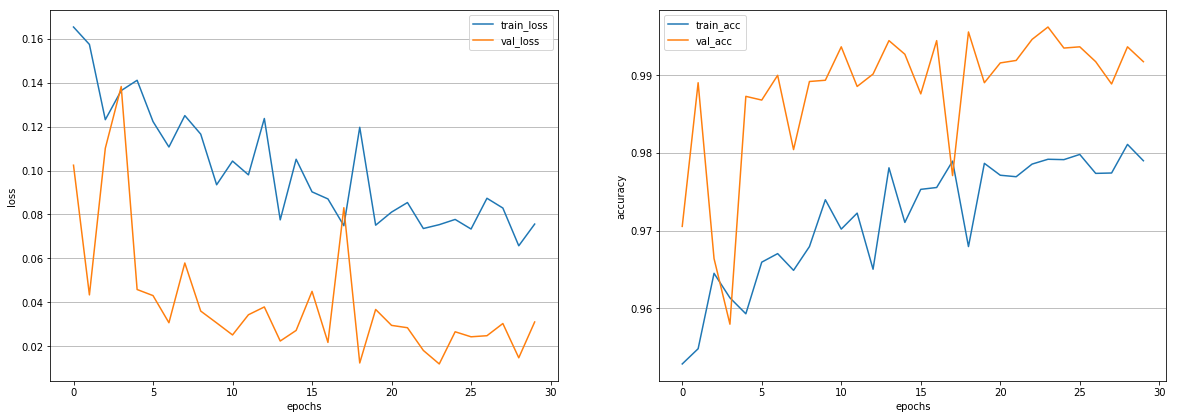

In [0]:
loss, acc, val_loss, val_acc = zip(*history)
fig = plt.figure(figsize=(20, 15))

losses = fig.add_subplot(2,2,3)
losses.plot(loss, label="train_loss")
losses.plot(val_loss, label="val_loss")
losses.legend(loc='best')
losses.grid(axis = 'y')
losses.set_xlabel("epochs")
losses.set_ylabel("loss")

accs = fig.add_subplot(2,2,4)
accs.plot(acc, label="train_acc")
accs.plot(val_acc, label="val_acc")
accs.legend(loc='best')
accs.grid(axis = 'y')
accs.set_xlabel("epochs")
accs.set_ylabel("accuracy")

plt.show()

# Submission

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [0]:
submit.to_csv('model-resnet18_train100_batch64_epoch30.csv', index=False)